In [1]:
import os
import shutil
import random
import numpy as np
import skimage.io as skio
import matplotlib.pyplot as plt
%matplotlib inline
all_splits = ['train', 'val', 'test', 'novel_object', 'novel_scene', 'novel_state']
pickup_object_root = '/mnt/huangjiangyong/VRKitchen/pickup_object'
pickup_object_seg_root = '/mnt/huangjiangyong/VRKitchen/pickup_object_seg'
reorient_object_root = '/mnt/huangjiangyong/VRKitchen/reorient_object'
open_drawer_root = '/mnt/huangjiangyong/VRKitchen/open_drawer'
close_drawer_root = '/mnt/huangjiangyong/VRKitchen/close_drawer'

In [2]:
def create_split(data_root):
    # before rearrangement, place all samples into a common directory named `data_pool`
    data_pool = os.path.join(data_root, 'data_pool')
    sample_list_raw = os.listdir(data_pool)
    sample_list = []

    # check insufficient stages
    for fname in sample_list_raw:
        npz_file = np.load(os.path.join(data_pool, fname), allow_pickle=True)
        if len(npz_file['gt']) < 4:
            print(f'Remove {fname} with {len(npz_file["gt"])} stages')
            os.remove(os.path.join(data_pool, fname))
        else:
            sample_list.append(fname)

    random.seed(0)
    print(f'Shuffling {len(sample_list)} demos')
    random.shuffle(sample_list)
    total_num = len(sample_list)

    train_num = int(0.7*total_num)
    val_num = int(0.85*total_num) - train_num

    for fname in sample_list[:train_num]:
        fname_new = fname.replace(' ', '_')
        shutil.move(os.path.join(data_pool, fname), os.path.join(data_root, 'train', fname_new))
    print(f'Finish preparing {train_num} demos for training')

    for fname in sample_list[train_num: train_num+val_num]:
        fname_new = fname.replace(' ', '_')
        shutil.move(os.path.join(data_pool, fname), os.path.join(data_root, 'val', fname_new))
    print(f'Finish preparing {val_num} demos for validation')

    for fname in sample_list[train_num+val_num:]:
        fname_new = fname.replace(' ', '_')
        shutil.move(os.path.join(data_pool, fname), os.path.join(data_root, 'test', fname_new))
    print(f'Finish preparing {total_num-train_num-val_num} demos for test')


def visualize_pos_scatter(data_root):
    # visualize the object position distribution
    obj_pos_list = []
    height_list = []
    for split in all_splits:
        demo_dir = os.path.join(data_root, split)
        for fname in os.listdir(demo_dir):
            npz_file = np.load(os.path.join(demo_dir, fname), allow_pickle=True)
            for i in range(len(npz_file['gt'])):
                obj_pos = npz_file['gt'][i]['position_rotation_world'][0][[0, 2]] - npz_file['gt'][i]['robot_base'][0][[0, 2]]
                obj_pos_list.append(obj_pos)
                height = npz_file['gt'][i]['position_rotation_world'][0][1] - npz_file['gt'][i]['robot_base'][0][1]
                height_list.append(height)
    obj_pos_list = np.stack(obj_pos_list)
    height_list = np.array(height_list)
    plt.figure()
    plt.scatter(obj_pos_list[:, 0], obj_pos_list[:, 1])
    print(f'Visualize {obj_pos_list.shape[0]} samples')
    print(f'x: {obj_pos_list[:, 0].max()} - {obj_pos_list[:, 0].min()} = {obj_pos_list[:, 0].max()-obj_pos_list[:, 0].min()}')
    print(f'y: {obj_pos_list[:, 1].max()} - {obj_pos_list[:, 1].min()} = {obj_pos_list[:, 1].max()-obj_pos_list[:, 1].min()}')
    plt.figure()
    plt.hist(height_list)
    print(f'z: {height_list.max()} - {height_list.min()} = {height_list.max()-height_list.min()}')


def check_stage_sufficiency(data_dir):
    # check demos with insufficient stages
    for fname in os.listdir(data_dir):
        npz_file = np.load(os.path.join(data_dir, fname), allow_pickle=True)
        if len(npz_file['gt']) < 4:
            print(f'Remove {fname} with {len(npz_file["gt"])} stages')
            os.remove(os.path.join(data_dir, fname))

In [2]:
create_split(pickup_object_root)

Shuffling 801 demos
Finish preparing 560 demos for training
Finish preparing 120 demos for validation
Finish preparing 121 demos for test


In [17]:
# test a sample
npz_path = '/mnt/huangjiangyong/VRKitchen/pickup_object/test/Steven-pickup_object-0-1--1-20-9-0-Fri_Nov__4_18:49:18_2022.npz'
npz_file = np.load(npz_path, allow_pickle=True)
list(npz_file.keys())

['gt', 'info']

In [18]:
gt = npz_file['gt']
len(gt), gt[0].keys()

(4,
 dict_keys(['images', 'keyframe', 'instruction', 'template_actions', 'diff', 'robot_base', 'position_rotation_world', 'gripper_joint_positions', 'joint_positions', 'joint_velocities', 'gripper_open', 'target']))

In [19]:
[frame['keyframe'] for frame in gt], [frame['instruction'] for frame in gt], [frame['gripper_open'] for frame in gt]

([False, True, False, True],
 ['the bottle should be twenty centimeters above the ground.',
  'the bottle should be twenty centimeters above the ground.',
  'the bottle should be twenty centimeters above the ground.',
  'the bottle should be twenty centimeters above the ground.'],
 [True, True, False, False])

In [20]:
[frame['template_actions'] for frame in gt], [frame['robot_base'] for frame in gt], [frame['position_rotation_world'] for frame in gt]

([(array([-4.9999962e+00,  1.6661997e+01, -1.9073486e-06], dtype=float32),
   array([ 0.27059809, -0.27059812,  0.65328142, -0.6532815 ])),
  (array([-9.9999619e-01,  1.6661997e+01, -1.9073486e-06], dtype=float32),
   array([ 0.27059809, -0.27059812,  0.65328142, -0.6532815 ])),
  (array([-9.99996349e-01,  3.66619989e+01, -3.27666757e-06]),
   array([ 0.27059809, -0.27059812,  0.65328142, -0.6532815 ])),
  (array([-9.99996349e-01,  3.66619989e+01, -3.27666757e-06]),
   array([ 0.27059809, -0.27059812,  0.65328142, -0.6532815 ]))],
 [(array([-45.409     ,   0.56199694, -20.        ], dtype=float32),
   array([ 7.0710689e-01, -7.0710683e-01, -1.8626451e-09,  6.9849193e-10],
         dtype=float32)),
  (array([-45.409     ,   0.56199694, -20.        ], dtype=float32),
   array([ 7.0710689e-01, -7.0710683e-01, -1.8626451e-09,  6.9849193e-10],
         dtype=float32)),
  (array([-45.409     ,   0.56199694, -20.        ], dtype=float32),
   array([ 7.0710689e-01, -7.0710683e-01, -1.8626451e-

In [7]:
[frame['diff'] for frame in gt], [frame['target'] for frame in gt]

([-19.999745845794678,
  -19.99999713897705,
  -19.98699140548706,
  -0.18418121337890625],
 [(-1, 20), (-1, 20), (-1, 20), (-1, 20)])

Visualize 59104 samples
x: 89.38887965225078 - -88.536203501735 = 177.92508315398578
y: 87.3430470439572 - -88.7598895122 = 176.1029365561572
z: 64.84346301676409 - 6.144667304002644 = 58.698795712761445


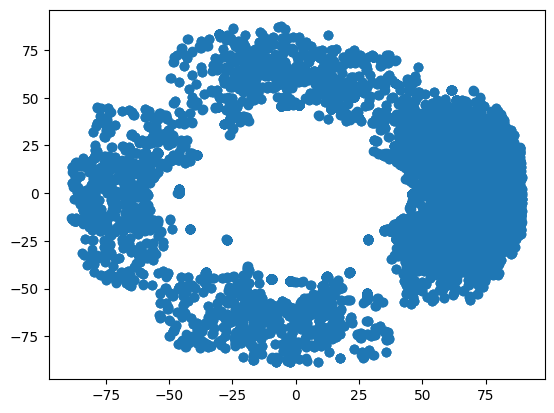

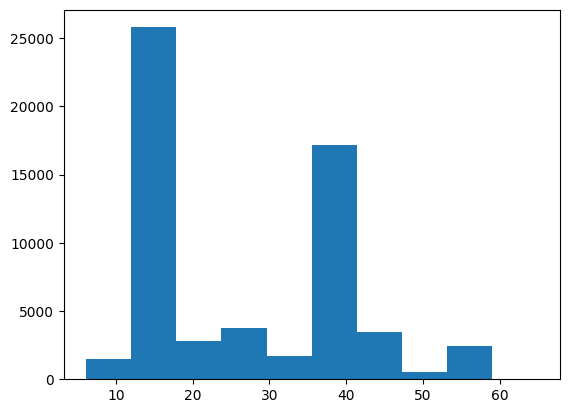

In [3]:
visualize_pos_scatter(pickup_object_root)

In [33]:
for split in all_splits:
    data_dir = os.path.join('/mnt/huangjiangyong/VRKitchen/pickup_object', split)
    print(f'Check {data_dir}')
    check_stage_sufficiency(data_dir=data_dir)

Check /mnt/huangjiangyong/VRKitchen/pickup_object/train
Check /mnt/huangjiangyong/VRKitchen/pickup_object/val
Check /mnt/huangjiangyong/VRKitchen/pickup_object/test
Check /mnt/huangjiangyong/VRKitchen/pickup_object/novel_object
Check /mnt/huangjiangyong/VRKitchen/pickup_object/novel_scene
Check /mnt/huangjiangyong/VRKitchen/pickup_object/novel_state


In [13]:
for split in all_splits:
    data_dir = os.path.join('/mnt/huangjiangyong/VRKitchen/reorient_object', split)
    print(f'Check {data_dir}')
    check_stage_sufficiency(data_dir=data_dir)

Check /mnt/huangjiangyong/VRKitchen/reorient_object/train
Check /mnt/huangjiangyong/VRKitchen/reorient_object/val
Check /mnt/huangjiangyong/VRKitchen/reorient_object/test
Check /mnt/huangjiangyong/VRKitchen/reorient_object/novel_object
Remove AWS-reorient_object-9-0-9-(-1, 45)-0-3-1-2-Sun Nov  6 05:50:23 2022.npz with 2 stages
Remove AWS-reorient_object-9-0-9-(-1, 45)-0-3-0-2-Sun Nov  6 05:50:16 2022.npz with 2 stages
Check /mnt/huangjiangyong/VRKitchen/reorient_object/novel_scene
Check /mnt/huangjiangyong/VRKitchen/reorient_object/novel_state


In [5]:
create_split(reorient_object_root)

Remove AWS-reorient_object-2-0-10-(-1, 45)-0-1-1-1-Sat Nov  5 19:34:05 2022.npz with 3 stages
Remove AWS-reorient_object-2-0-10-(-1, 45)-0-1-0-1-Sat Nov  5 19:33:55 2022.npz with 3 stages
Remove AWS-reorient_object-7-0-1-(-1, 0)-0-1-0-2-Sun Nov  6 01:53:42 2022.npz with 3 stages
Remove AWS-reorient_object-7-0-1-(-1, 0)-0-1-1-2-Sun Nov  6 01:53:48 2022.npz with 3 stages
Shuffling 578 demos
Finish preparing 404 demos for training
Finish preparing 87 demos for validation
Finish preparing 87 demos for test


In [21]:
# test a sample
npz_path = '/mnt/huangjiangyong/VRKitchen/reorient_object/test/AWS-reorient_object-7-0-9-(-1,_45)-0-0-1-0-Sun_Nov__6_01:14:45_2022.npz'
npz_file = np.load(npz_path, allow_pickle=True)
gt = npz_file['gt']
len(gt), gt[0].keys(), [frame['instruction'] for frame in gt], [frame['gripper_open'] for frame in gt], [frame['diff'] for frame in gt], [frame['position_rotation_world'] for frame in gt]

(4,
 dict_keys(['images', 'instruction', 'template_actions', 'diff', 'robot_base', 'position_rotation_world', 'gripper_joint_positions', 'joint_positions', 'joint_velocities', 'gripper_open', 'target', 'keyframe']),
 ['gt', 'info'],
 ['reorient the bottle forty-five degrees away from the up axis',
  'reorient the bottle forty-five degrees away from the up axis',
  'reorient the bottle forty-five degrees away from the up axis',
  'reorient the bottle forty-five degrees away from the up axis'],
 [True, True, False, False],
 [44.478755360221754,
  34.024452744431656,
  34.024452744431656,
  6.468525234034331],
 [(array([  4.07257829,  38.83575661, 138.87398619]),
   array([-0.25597218,  0.29272205, -0.64699709,  0.65588627])),
  (array([ -1.73432902,  15.52330938, 138.7927384 ]),
   array([ 0.49712954,  0.50262474, -0.50011789,  0.50011267])),
  (array([ -1.23344989,   3.89643178, 139.04853424]),
   array([ 0.49857502,  0.50190229, -0.4983281 ,  0.50118474])),
  (array([ -1.15163716,  19.

Visualize 4244 samples
x: 53.8731754401623 - -50.88235023724126 = 104.75552567740357
y: 54.7811553648684 - -60.57277132427984 = 115.35392668914824
z: 73.367651977588 - 3.1055786788745077 = 70.26207329871349


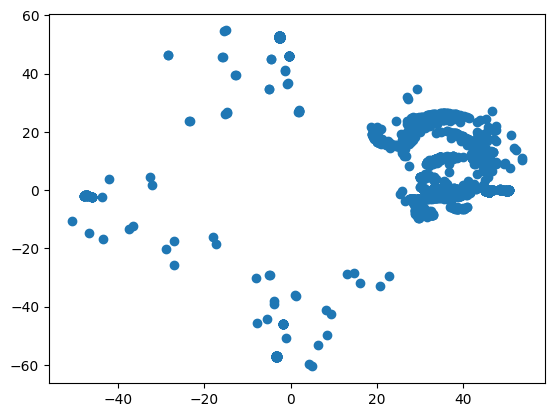

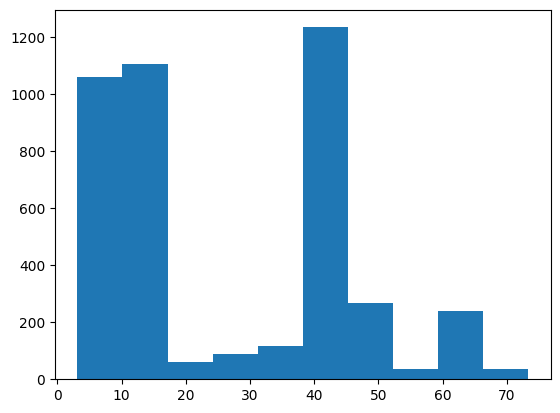

In [16]:
visualize_pos_scatter(reorient_object_root)

In [4]:
create_split(open_drawer_root)

Remove Steven-open_drawer-0-0-0.5-1.0-1-Sun Nov  6 19:57:18 2022.npz with 2 stages
Remove Steven-open_drawer-0-0-0.75-1.0-1-Sun Nov  6 19:58:42 2022.npz with 2 stages
Remove Steven-open_drawer-7-0-0.75-1.0-4-Sun Nov  6 21:55:15 2022.npz with 2 stages
Remove Steven-open_drawer-8-0-0.75-1.0-15-Sun Nov  6 22:32:31 2022.npz with 2 stages
Remove Ziheng-open_drawer-1-0-0.75-1.0-0-Sun Nov  6 23:24:23 2022.npz with 2 stages
Remove Steven-open_drawer-7-0-0.75-1.0-14-Sun Nov  6 22:00:04 2022.npz with 2 stages
Remove Steven-open_drawer-5-0-0.75-1.0-7-Sun Nov  6 21:22:24 2022.npz with 2 stages
Remove Steven-open_drawer-7-0-0.75-1.0-12-Sun Nov  6 21:45:56 2022.npz with 2 stages
Remove Steven-open_drawer-2-0-0.75-1.0-3-Sun Nov  6 20:37:07 2022.npz with 2 stages
Remove Steven-open_drawer-0-0-0.75-1.0-1-Sun Nov  6 19:58:39 2022.npz with 2 stages
Remove Steven-open_drawer-5-0-0.75-1.0-14-Sun Nov  6 21:17:42 2022.npz with 2 stages
Remove Steven-open_drawer-1-0-0.75-1.0-9-Sun Nov  6 20:24:26 2022.npz wit

In [5]:
for split in all_splits:
    data_dir = os.path.join('/mnt/huangjiangyong/VRKitchen/open_drawer', split)
    print(f'Check {data_dir}')
    check_stage_sufficiency(data_dir=data_dir)

Check /mnt/huangjiangyong/VRKitchen/open_drawer/train
Check /mnt/huangjiangyong/VRKitchen/open_drawer/val
Check /mnt/huangjiangyong/VRKitchen/open_drawer/test
Check /mnt/huangjiangyong/VRKitchen/open_drawer/novel_object
Remove Steven-open_drawer-9-0-0.75-1.0-15-Sun Nov  6 22:37:11 2022.npz with 2 stages
Remove Ziheng-open_drawer-9-0-0.75-1.0-9-Mon Nov  7 03:59:00 2022.npz with 2 stages
Remove Ziheng-open_drawer-9-0-0.75-1.0-1-Mon Nov  7 03:52:18 2022.npz with 2 stages
Check /mnt/huangjiangyong/VRKitchen/open_drawer/novel_scene
Remove Ziheng-open_drawer-3-0-0.75-1.0-16-Mon Nov  7 00:20:37 2022.npz with 2 stages
Remove Ziheng-open_drawer-2-0-0.75-1.0-19-Sun Nov  6 23:56:57 2022.npz with 2 stages
Remove Ziheng-open_drawer-0-0-0.5-1.0-16-Sun Nov  6 22:48:28 2022.npz with 2 stages
Remove Steven-open_drawer-1-0-0.75-1.0-17-Sun Nov  6 20:33:00 2022.npz with 2 stages
Check /mnt/huangjiangyong/VRKitchen/open_drawer/novel_state
Remove Steven-open_drawer-5-0-0.5-0.75-14-Sun Nov  6 21:16:16 2022.n

Visualize 8000 samples
x: 91.41332481912832 - -86.05990373495393 = 177.47322855408225
y: 73.53400183972269 - -89.25103132751494 = 162.78503316723763
z: 111.09552605887853 - 26.271853070016796 = 84.82367298886174


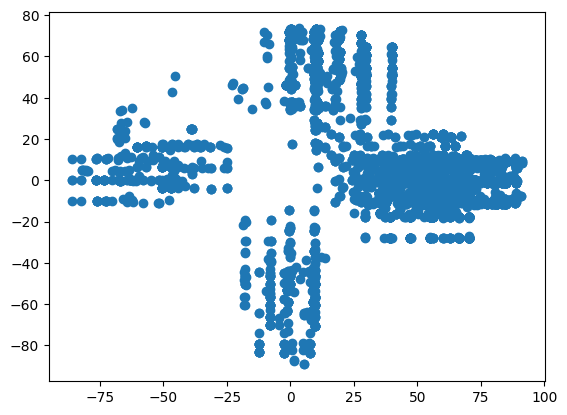

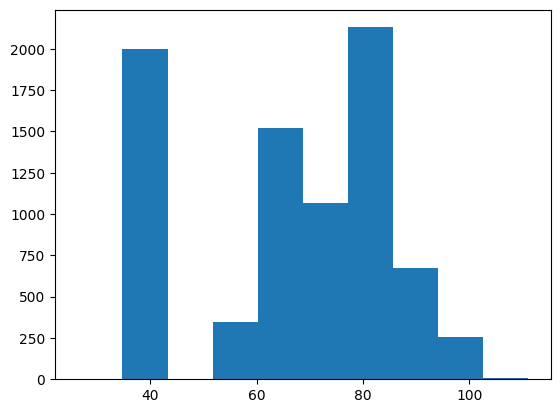

In [6]:
visualize_pos_scatter(open_drawer_root)

In [4]:
create_split(close_drawer_root)

Remove Ziheng-close_drawer-6-1-1.0-0.0-6-Tue Nov  8 01:38:31 2022.npz with 2 stages
Remove Ziheng-close_drawer-6-0-1.0-0.0-10-Tue Nov  8 00:46:46 2022.npz with 2 stages
Remove Ziheng-close_drawer-1-0-1.0-0.0-11-Mon Nov  7 20:41:31 2022.npz with 2 stages
Remove Ziheng-close_drawer-0-0-1.0-0.5-6-Mon Nov  7 19:34:19 2022.npz with 3 stages
Remove Steven-close_drawer-4-0-0.5-0.0-7-Mon Nov  7 18:41:17 2022.npz with 3 stages
Remove Ziheng-close_drawer-1-0-0.75-0.5-9-Mon Nov  7 20:32:14 2022.npz with 3 stages
Remove Ziheng-close_drawer-1-0-0.5-0.0-10-Mon Nov  7 20:01:56 2022.npz with 3 stages
Remove Ziheng-close_drawer-7-0-0.5-0.0-3-Tue Nov  8 03:58:06 2022.npz with 3 stages
Remove Ziheng-close_drawer-4-1-0.75-0.0-10-Mon Nov  7 22:59:46 2022.npz with 2 stages
Remove Ziheng-close_drawer-2-0-0.75-0.0-0-Mon Nov  7 20:56:34 2022.npz with 3 stages
Remove Ziheng-close_drawer-1-0-1.0-0.5-15-Mon Nov  7 20:17:22 2022.npz with 2 stages
Remove Ziheng-close_drawer-1-0-0.75-0.0-7-Mon Nov  7 20:21:27 2022.n

In [5]:
for split in all_splits:
    data_dir = os.path.join('/mnt/huangjiangyong/VRKitchen/close_drawer', split)
    print(f'Check {data_dir}')
    check_stage_sufficiency(data_dir=data_dir)

Check /mnt/huangjiangyong/VRKitchen/close_drawer/train
Check /mnt/huangjiangyong/VRKitchen/close_drawer/val
Check /mnt/huangjiangyong/VRKitchen/close_drawer/test
Check /mnt/huangjiangyong/VRKitchen/close_drawer/novel_object
Remove Ziheng-close_drawer-9-0-0.25-0.0-12-Tue Nov  8 05:31:35 2022.npz with 3 stages
Remove Ziheng-close_drawer-9-0-0.5-0.0-12-Tue Nov  8 05:33:00 2022.npz with 3 stages
Remove Ziheng-close_drawer-9-1-1.0-0.75-15-Tue Nov  8 06:01:57 2022.npz with 2 stages
Remove Ziheng-close_drawer-9-1-1.0-0.75-12-Tue Nov  8 06:09:20 2022.npz with 2 stages
Remove Ziheng-close_drawer-9-0-0.75-0.0-7-Tue Nov  8 04:46:59 2022.npz with 3 stages
Remove Ziheng-close_drawer-9-0-0.25-0.0-12-Tue Nov  8 05:31:44 2022.npz with 3 stages
Remove Ziheng-close_drawer-9-1-0.5-0.0-15-Tue Nov  8 05:54:14 2022.npz with 3 stages
Remove Ziheng-close_drawer-9-0-0.75-0.0-7-Tue Nov  8 04:47:07 2022.npz with 2 stages
Remove Ziheng-close_drawer-9-1-0.25-0.0-15-Tue Nov  8 05:53:31 2022.npz with 2 stages
Remove

Visualize 1536 samples
x: 92.59209701132443 - -74.31480907002287 = 166.9069060813473
y: 71.02744757876371 - -88.90023861725028 = 159.927686196014
z: 118.51583588092971 - 6.817335978151917 = 111.6984999027778


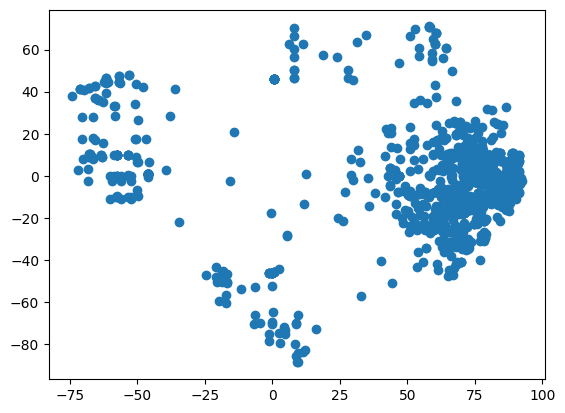

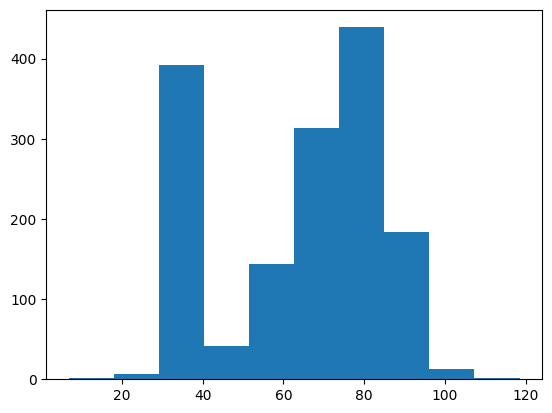

In [6]:
visualize_pos_scatter(close_drawer_root)

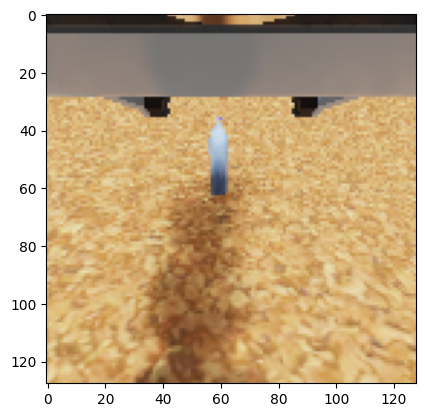

In [9]:
# visualize observation in offline data
train_wrist = '/mnt/huangjiangyong/VRKitchen/overfit/train/AWS-pickup_object-7-1--1-30-9-7-Tue Nov 15 09:04:10 2022.npz'
npz_file = np.load(train_wrist, allow_pickle=True)
train_wrist = npz_file['gt'][0]['images'][3]['rgb'][..., :3]
plt.imshow(train_wrist)

0.98272705078125

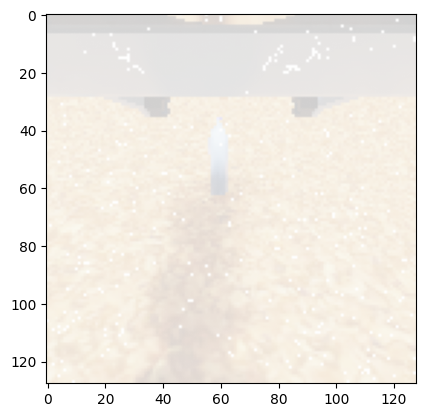

In [29]:
# visualize noise in rendering, white points are identical points
eval_wrist = skio.imread('eval_wrist.png')
diff = train.mean(-1) - eval.mean(-1)
y, x = diff.nonzero()
tmp = np.concatenate([train.copy(), np.ones((128, 128, 1))], axis=-1)
tmp[y, x, -1] = 50
tmp /= 255
plt.imshow(tmp)
print(f'Percentage of non-equal pixels {y.shape[0]/128**2}')